In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from torch.distributions.multivariate_normal import MultivariateNormal

import torch
import torch.nn as nn
from pyro.distributions import Binomial, Normal
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch import optim

from tqdm import tqdm

import scipy.stats as stats
from scipy.stats import bernoulli, binom
from sklearn import linear_model


np.random.seed(42)

# Size

n = 200
d = 500
# K = 100
p = 0.5


REP = 15

num_epochs = 200
EPSILON = 1
lambda_val = 0.1
BATCH_SIZE = 64


first = True

#Genarating Genotypes

# toy_genotypes = np.random.binomial(2, p, (n * 3, d))
# np.random.shuffle(toy_genotypes)


toy_genotypes = binom.rvs(2, p, size=(n * 3, d))
np.random.shuffle(toy_genotypes)

print(toy_genotypes.shape)

print(np.mean(toy_genotypes))
print(np.var(toy_genotypes))

(600, 500)
1.0002666666666666
0.4999532622222222


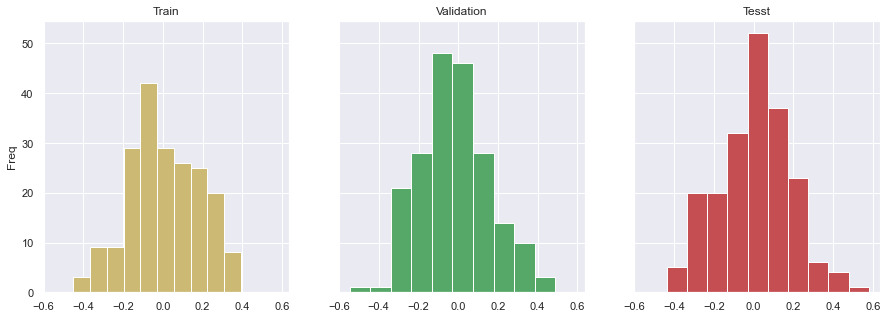

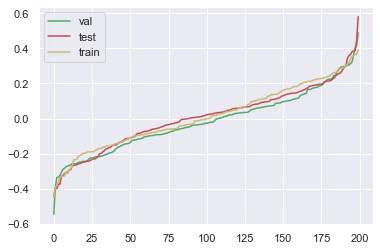

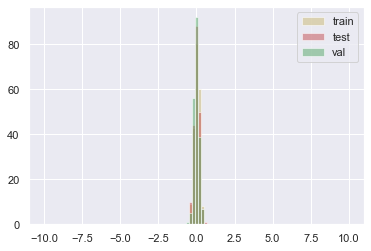

0.035111599604922515 validation
3.2671264818631963e-07 train
0.033784597140285214 test



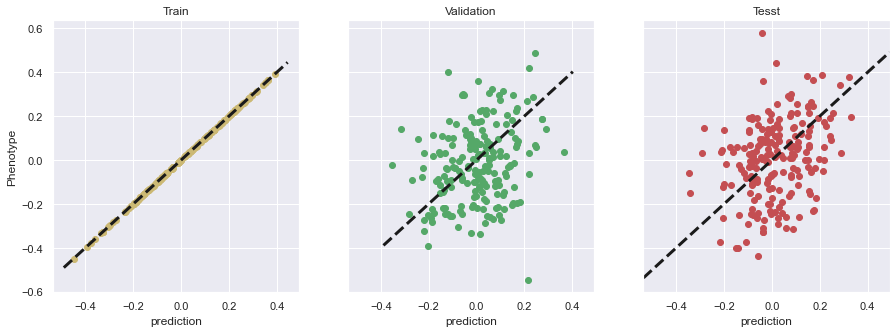

In [2]:
def simulate_phenotypes(given_genotypes, pis=(0.95, 0.05), gammas=np.array((0., 1.))):
    
    
    n, p = given_genotypes.shape
    
    mixture_assignment = np.random.multinomial(1, pis, size=p)
    
    std_beta = 1
    
    betas = np.random.normal(loc=0.0,
                             scale=gammas[np.where(mixture_assignment)[1]]*std_beta,
                             size=p)
    
    mult = np.dot(given_genotypes, betas)
    g_var = np.var(mult, ddof=1)
    
    e = np.random.normal(0, np.sqrt(g_var), n)
    
    y = mult + e

    y -= np.mean(y)
    y /= np.var(y)
    
    return y, betas



test_genotypes = toy_genotypes[0:n,:]
val_genotypes = toy_genotypes[n:2*n,:]
train_genotypes = toy_genotypes[2 * n:,:]

if first:

    toy_phenotypes, betas = simulate_phenotypes(toy_genotypes)
    test_phenotypes = toy_phenotypes[0:n,]
    val_phenotypes = toy_phenotypes[n:2*n,]
    train_phenotypes = toy_phenotypes[2 * n:,]
else:
    test_phenotypes, betas_test = simulate_phenotypes(test_genotypes)
    val_phenotypes, betas_val = simulate_phenotypes(val_genotypes)
    train_phenotypes, betas_train = simulate_phenotypes(train_genotypes)

figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,5))

axis[0].hist(train_phenotypes, color='y')
axis[0].set_title("Train")

axis[1].hist(val_phenotypes, color='g')
axis[1].set_title("Validation")

axis[2].hist(test_phenotypes, color='r')
axis[2].set_title("Tesst")

for ax in axis.flat:
    ax.set(ylabel='Freq')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()

print("")
plt.show()
figure.savefig('phenotypes_dist.pdf')


plt.plot(np.sort(val_phenotypes), color='g', label='val')
plt.plot(np.sort(test_phenotypes), color='r', label='test')
plt.plot(np.sort(train_phenotypes), color='y', label='train')
plt.legend(loc='upper left')
print("")
plt.savefig('phenotypes_dist_cont.pdf')
plt.show()

bins = np.linspace(-10, 10, 100)

plt.hist(train_phenotypes, bins, alpha=0.5, color='y', label='train')
plt.hist(test_phenotypes, bins, alpha=0.5, color='r', label='test')
plt.hist(val_phenotypes, bins, alpha=0.5, color='g', label='val')

plt.legend(loc='upper right')
plt.savefig('phenotypes_dist_together.pdf')
print("")
plt.show()



from sklearn import svm

reg = linear_model.Ridge(alpha=.5)
reg.fit(train_genotypes, train_phenotypes)


figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,5))


per = reg.predict(val_genotypes)

axis[1].scatter(per, val_phenotypes, color='g')
axis[1].set_title("Validation")
xpoints = ypoints = plt.xlim()
axis[1].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

EPSILON_PREV = np.mean((val_phenotypes - per) ** 2)

print(np.mean((val_phenotypes - per) ** 2), 'validation')

del per

per = reg.predict(train_genotypes)

axis[0].scatter(per, train_phenotypes, color='y')
axis[0].set_title("Train")
xpoints = ypoints = plt.xlim()
axis[0].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

print(np.mean((train_phenotypes - per) ** 2), 'train')

del per

per = reg.predict(test_genotypes)


axis[2].scatter(per, test_phenotypes, color='r')
axis[2].set_title("Tesst")

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
print(np.mean((test_phenotypes - per) ** 2), 'test')




for ax in axis.flat:
    ax.set(ylabel='Phenotype', xlabel='prediction')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()

print("")
plt.show()
figure.savefig('linear_model_res.pdf')






In [3]:
class Loader(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, genotype_matrix, phenotypes, batch_size=1):

        self.phenotypes = phenotypes
        self.genotype_matrix = genotype_matrix

        self.batch_size = batch_size

    def __len__(self):
        return len(self.genotype_matrix)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        real_samples = self.genotype_matrix[idx, ]        
        samples = real_samples
        labels = self.phenotypes[idx, ]
        batch = {'x': samples, 'y': labels}

        return batch

    
    
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data    

dataset = Loader(train_genotypes, train_phenotypes)


from scipy.stats import gamma
alpha_gam = 2
beta_gam = 1

from scipy.stats import norm


def prior_sample(size=1):
    sigma = gamma.rvs(alpha_gam, scale=1/beta_gam, size=size)
    beta = norm.rvs(loc=0, scale=sigma, size=size)
    return beta, sigma

def prior_prob(beta, sigma):
    p_sig = gamma.pdf(sigma, alpha_gam, scale=1/beta_gam)
    p_beta = norm.pdf(beta, loc=0, scale=sigma)

    p_beta[np.where(np.isnan(p_beta))] = 1e-5
    
    return p_beta, p_sig


from scipy.stats import multivariate_normal

def metropolis_heisting(cur_beta, cur_sigma, cur_prob_theta, geno_mat, h_classifier):
    
#     changed_value = np.full(cur_theta_prob.shape, 1)
    counter = 0

    while(True):
        new_sigma = multivariate_normal(cur_sigma, var).rvs(size=1)
        new_beta = multivariate_normal(cur_beta, var).rvs(size=1)

        new_prior, _ = prior_prob(new_beta, new_sigma)
        new_ys = np.dot(geno_mat, new_beta)
        with torch.no_grad():
            r_value = h_classifier(new_ys, new_prior).cpu().detach().numpy()
            r_value = np.mean(r_value, axis=0)
            r_value = r_value / (1 - r_value)
            new_theta_prob = r_value * new_prior


            rho = (new_theta_prob) / (cur_prob_theta + 1e-7)
            rho[rho > 1] = 1
    #         rho = rho * changed_value
    #        rho = min(1, (new_theta_prob)/(cur_theta_prob))
            random_num = np.random.rand()
        
            if np.isnan(np.sum(rho)):
                print(np.isnan(np.sum(cur_prob_theta)))
                print(np.isnan(np.sum(new_prob_theta)))

            if random_num < np.mean(rho):
                cur_beta = new_beta
                cur_sigma = new_sigma
                cur_theta_prob = new_theta_prob
                return cur_sigma, cur_beta, cur_theta_prob, new_ys

        counter += 1
        
        if counter > REP:
#             print("It Takes quite time :(")
            cur_beta = (new_beta + cur_beta) / 2
            cur_sigma = (new_sigma + cur_sigma) / 2
            cur_theta_prob = (new_theta_prob + cur_prob_theta) / 2
            return cur_sigma, cur_beta, cur_theta_prob, new_ys

class Classifier(nn.Module):
    
    def __init__(self, input_dim, num_classes=1):
        super(Classifier, self).__init__()
#         self.linear = nn.Linear(input_dim, 1)
#         self.activation = nn.Sigmoid()

        # Number of input features is 12.
        self.layer_1 = nn.Linear(input_dim, 1)
        self.layer_out = nn.Linear(2, 1)
        

        self.criterion = nn.BCEWithLogitsLoss()
        
    def cross_entropy(self, x, y):
        n_d, h_d = x.shape
        
        n_theta = x[0: int(n_d / 2),:]
        n_x = x[int(n_d / 2):,:]
        
        return (1 / n_d) * (torch.sum(torch.exp(-(n_theta))) + torch.sum(torch.exp(n_x)))
        
    def forward(self, y, beta, label=None):

        y = torch.Tensor(y).to(device)
        beta = torch.Tensor(beta).to(device)
        
        beta_summaries = self.layer_1(beta)
        x = torch.cat([y[:, None], torch.repeat_interleave(beta_summaries[None, :], y.shape[0], dim=0)], dim=1)
        x = self.layer_out(x)
        

        if label is not None:

            loss = self.criterion(x, label[:, None])
            return x, loss
        
        return x
    
    def get_n_params(model):
        pp=0
        for p in list(model.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp

  0%|          | 0/200 [00:00<?, ?it/s]

Running on the CPU
1
504


 10%|█         | 20/200 [04:45<48:26, 16.15s/it]

1.019000212156043
EPOCH 20
Total Error tensor(5.5384, grad_fn=<AddBackward0>)
Using proper sets


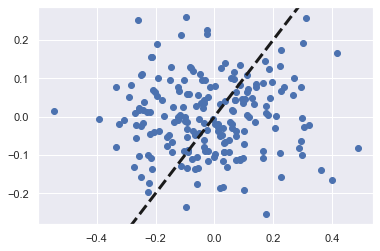

 20%|██        | 40/200 [12:27<1:38:21, 36.89s/it]

0.9990548187582952
EPOCH 40
Total Error tensor(5.7523, grad_fn=<AddBackward0>)
Using proper sets


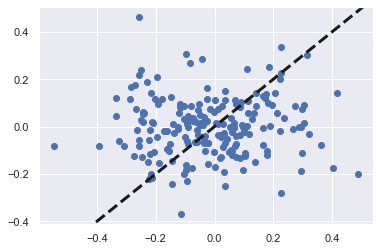

 26%|██▌       | 52/200 [31:57<1:30:56, 36.87s/it] 
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Library/Python/3.7/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-f51581d70ac7>", line 61, in <module>
    sampled_sigma, sampled_beta, prob_theta, sampled_y = metropolis_heisting(cur_beta, cur_sigma, cur_theta_prob, geno_batch, classifier)
  File "<ipython-input-3-bbacc351c9e5>", line 74, in metropolis_heisting
    new_beta = multivariate_normal(cur_beta, var).rvs(size=1)
  File "/Users/mehrabhamidi/Library/Python/3.7/lib/python/site-packages/scipy/stats/_multivariate.py", line 762, in rvs
    return self._dist.rvs(self.mean, self.cov, size, random_state)
  File "/Users/mehrabhamidi/Library/Python/3.7/lib/python/site-packages/scipy/stats/_multivariate.py", line 660, in rvs
    out = random_state.multivariate_normal(mean, cov, size)
  File "mtrand.pyx", line 4082, in numpy.random.mtrand.RandomState.multivariate_normal
  File "/Users/mehrabh

KeyboardInterrupt: 

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

print(EPSILON)


data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

classifier = Classifier(d).to(device)
print(classifier.get_n_params())

optimizer = optim.Adam(classifier
                         .parameters(), lr=0.0002)

losses = []
distances = []


denum = train_genotypes.shape[0] / BATCH_SIZE

losses = []

proper_beta_samples = []

import time
distance = 1

for epoch in tqdm(range(num_epochs)):
    
    error_sum = 0
    distance_sum = 0
    
#     var = np.eye(d) * (0.75 / (epoch + 1))
    var = np.eye(d) * 0.1 * distance

    cur_beta, cur_sigma = prior_sample(d)

    cur_ys = np.dot(train_genotypes, cur_beta)
    cur_ys -= np.mean(cur_ys)
    cur_ys /= np.var(cur_ys)
    cur_prior, _ = prior_prob(cur_beta, cur_sigma)
    cur_r_value = classifier(cur_ys, cur_beta).cpu().detach().numpy()
    cur_r_value = np.mean(cur_r_value, axis=0)
    cur_r_value = cur_r_value / (1 - cur_r_value)

    cur_theta_prob = cur_r_value * cur_prior

    for n_batch, batch in enumerate(data_loader):
        
        optimizer.zero_grad()
        
        N = batch['x'].size(0)
        
        geno_batch = batch['x'].cpu().detach().numpy()
        pheno_batch = batch['y'].cpu().detach().numpy()
        
        sampled_sigma, sampled_beta, prob_theta, sampled_y = metropolis_heisting(cur_beta, cur_sigma, cur_theta_prob, geno_batch, classifier)
#         sampled_y = torch.sigmoid(torch.tensor(sampled_y)).numpy()
        
#         sampled_y = sampled_y
        sampled_y -= sampled_y.mean()
        sampled_y /= sampled_y.std()
#         sampled_y[sampled_y > 0] = 1.
#         sampled_y[sampled_y <= 0] = 0.
        
        distance = np.mean((sampled_y - pheno_batch) ** 2)
        
#         print(distance)
        distance_sum += distance
        
        _, loss_f = classifier(sampled_y, sampled_beta, torch.full(sampled_y.shape, 0.0))
        _, loss_r = classifier(pheno_batch, sampled_beta, torch.full(pheno_batch.shape, 1.0))
        
#         _, loss_f = classifier(sampled_y, sampled_beta, torch.full(sampled_y.shape, 0.0))
#         loss_f *= ((distance ** 2))
                             
#         _, loss_r = classifier(pheno_batch, sampled_beta, torch.full(pheno_batch.shape, 1.0))
#         loss_r *= ((distance ** 2))
        
        loss = loss_f + loss_r
        loss *= (distance ** 2)
#         loss += lambda_val * torch.abs(torch.norm(torch.tensor(sampled_beta), float('inf')))
        loss.backward()

        
        optimizer.step()
        error_sum += loss
        
        if distance <= EPSILON:
            proper_beta_samples.append(sampled_beta)
#             print("ADDED")
            
        cur_beta = sampled_beta.copy()
        cur_sigma = sampled_sigma.copy()
        cur_theta_prob = prob_theta
        
    if epoch % int(num_epochs / 10) == 0 and epoch >= int(num_epochs / 10):
        print(distance)
        print("EPOCH", epoch)
        print("Total Error", error_sum)

        if len(proper_beta_samples) > 0:
                print("Using proper sets")
                proper_beta_samples_val = np.array(proper_beta_samples)
                proper_beta_samples_val = np.mean(proper_beta_samples_val, axis=0)
                proper_beta_samples_val.shape

                val_y = np.dot(val_genotypes, proper_beta_samples_val)

        else:   
                val_y = np.dot(val_genotypes, sampled_beta)
                
        val_y -= np.mean(val_y)
        val_y /= np.var(val_y)

        wrong_preds = np.sum(np.abs(val_y - val_phenotypes))

        plt.scatter(val_phenotypes, val_y)
        xpoints = ypoints = plt.xlim()
        plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
        plt.show()
#     print(distance_sum / denum)
        
    losses.append([error_sum / denum])
    distances.append([distance_sum / denum])
        

In [ ]:
plt.plot(np.arange(epoch + 1), losses)
plt.show()
plt.plot(np.arange(epoch + 1), distances)
plt.show()
distances = np.array(distances)
plt.plot(np.arange(len(distances[distances < EPSILON])), distances[distances < EPSILON])
print(np.mean(distances))
plt.show()

In [ ]:
proper_beta_samples_np = np.array(proper_beta_samples).T
print(proper_beta_samples_np.T.shape)
proper_beta_samples_mean = np.mean(proper_beta_samples_np.T, axis=0)
print(proper_beta_samples_mean.shape)

if first:
    plt.hist(proper_beta_samples_mean)
    plt.show()
    plt.hist(betas)
    plt.show()
else:
    plt.hist(proper_beta_samples_mean)
    plt.show()
    plt.hist(betas_train)
    plt.show()


In [ ]:
if first:
    to_plot = []
    for i in range(proper_beta_samples_np[betas != 0].shape[0]):
        to_plot += [proper_beta_samples_np[betas != 0][i, :]]

    print(len(to_plot))
    print(to_plot[0].shape)
    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(to_plot)) + 1, betas[betas!=0])
    fig.savefig('boxplot2_new.pdf',bbox_inches='tight')
    plt.show()


    ind = np.argpartition(np.abs(proper_beta_samples_mean), -int(0.05 * d))[-int(0.05 * d):]

    to_plot = []
    for i in ind:
        to_plot += [proper_beta_samples_np[i, :]]
    # print(len(to_plot))


    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(ind)) + 1, betas[ind])
    fig.savefig('boxplot_oth_new.pdf',bbox_inches='tight')
    plt.show()


else:
    to_plot = []
    for i in range(proper_beta_samples_np[betas_train != 0].shape[0]):
        to_plot += [proper_beta_samples_np[betas_train != 0][i, :]]

    print(len(to_plot))
    print(to_plot[0].shape)
    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(to_plot)) + 1, betas_train[betas_train!=0])
    fig.savefig('boxplot2_new.pdf',bbox_inches='tight')
    plt.show()


    ind = np.argpartition(np.abs(proper_beta_samples_mean), -int(0.05 * d))[-int(0.05 * d):]

    to_plot = []
    for i in ind:
        to_plot += [proper_beta_samples_np[i, :]]
    # print(len(to_plot))


    fig=plt.figure(1,figsize=(20,20))
    ax=fig.add_subplot(111)
    bp=ax.boxplot(to_plot)

    plt.scatter(np.arange(len(ind)) + 1, betas_train[ind])
    fig.savefig('boxplot_oth_new.pdf',bbox_inches='tight')
    plt.show()

In [ ]:
figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,5))

# del per
per = np.dot(val_genotypes, proper_beta_samples_mean)
per -= np.mean(per)
per /= np.var(per)

axis[1].scatter(per, val_phenotypes, color='g')
axis[1].set_title("Validation")
xpoints = ypoints = plt.xlim()
axis[1].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

EPSILON_PREV = np.mean((val_phenotypes - per) ** 2)

print(np.mean((val_phenotypes - per) ** 2), 'validation')

del per

per = np.dot(train_genotypes, proper_beta_samples_mean)
per -= np.mean(per)
per /= np.var(per)

axis[0].scatter(per, train_phenotypes, color='y')
axis[0].set_title("Train")
xpoints = ypoints = plt.xlim()
axis[0].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

print(np.mean((train_phenotypes - per) ** 2), 'train')

del per

per = np.dot(test_genotypes, proper_beta_samples_mean)
per -= np.mean(per)
per /= np.var(per)

axis[2].scatter(per, test_phenotypes, color='r')
axis[2].set_title("Tesst")

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
print(np.mean((test_phenotypes - per) ** 2), 'test')




for ax in axis.flat:
    ax.set(ylabel='Phenotype', xlabel='prediction')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()

plt.show()
figure.savefig('proposed_model_res.pdf')


if first:
    print(np.mean(np.abs(proper_beta_samples_mean - betas)))
else:
    print(np.mean(np.abs(proper_beta_samples_mean - betas_train)))
    print(np.mean(np.abs(proper_beta_samples_mean - betas_test)))
    print(np.mean(np.abs(proper_beta_samples_mean - betas_val)))
